# The slow way to generate an ROC curve

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import auc, roc_curve
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
mpl.rcParams["figure.dpi"] = 150

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# load data
bbb = pd.read_pickle("data/bbb.pkl")
bbb["buyer_yes"] = rsm.ifelse(bbb["buyer"] == "yes", 1, 0)
bbb

,acctnum,gender,state,zip,zip3,first,last,book,nonbook,total,...,child,youth,cook,do_it,reference,art,geog,buyer,training,buyer_yes
0,10001,M,NY,10605,106,49,29,109,248,357,...,3,2,2,0,1,0,2,no,1,0
1,10002,M,NY,10960,109,39,27,35,103,138,...,0,1,0,1,0,0,1,no,1,0
2,10003,F,PA,19146,191,19,15,25,147,172,...,0,0,2,0,0,0,0,no,0,0
3,10004,F,NJ,07016,070,7,7,15,257,272,...,0,0,0,0,1,0,0,no,0,0
4,10005,F,NY,10804,108,15,15,15,134,149,...,0,0,1,0,0,0,0,no,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59996,F,NY,11967,119,9,9,15,12,27,...,1,0,0,0,0,0,0,no,1,0
49996,59997,F,NJ,08882,088,25,5,79,294,373,...,3,0,1,1,0,1,1,no,1,0
49997,59998,M,NJ,07410,074,3,3,15,178,193,...,0,0,0,0,1,0,0,no,1,0
49998,59999,M,NJ,07090,070,49,29,98,246,344,...,2,0,1,0,2,1,2,no,1,0


In [3]:
# review the data
rsm.describe(bbb)

# BookBinders Book Club

Information on purchasing history and demographics for 50,000 of the BookBinders Book Club's customers'. Variables included in the dataset are described below

## Variables

* acctnum: Customer account number
* gender: Customer gender - M=male, F=female
* state: State where customer lives (2-character abbreviation)
* zip: ZIP code (5-digit)
* zip3: First 3 digits of ZIP code
* first: Number of months since first purchase
* last: Number of months since most recent purchase
* book: Total dollars spent on books
* nonbook: Total dollars spent on non-book products
* total: Total dollars spent
* purch: Total number of books purchased
* child: Total number of children's books purchased
* youth: Total number of youth books purchased
* cook: Total number of cook books purchased 
* do_it: Total number of do-it-yourself books purchased 
* reference: Total number of reference books purchased 
* art: Total number of art books purchased 
* geog: Total number of geography books purchased 
* buyer: Did the customer buy The Art History of Florence?  (yes, no)
* training: Dummy variable that splits the dataset into a training (1) and validation (0) dataset

In [4]:
evar = [
    "gender",
    "last",
    "total",
    "child",
    "youth",
    "cook",
    "do_it",
    "reference",
    "art",
    "geog",
]

In [5]:
form = "buyer_yes ~ " + " + ".join(evar)
lr = smf.glm(formula=form, family=Binomial(link=logit()), data=bbb).fit()
# lr.summary()
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,gender[T.M],2.140,114.0%,1.995,2.295,< .001,***
2,last,0.910,-9.0%,0.905,0.915,< .001,***
3,total,1.001,0.1%,1.001,1.002,< .001,***
4,child,0.830,-17.0%,0.802,0.859,< .001,***
5,youth,0.893,-10.7%,0.849,0.940,< .001,***
6,cook,0.763,-23.7%,0.738,0.789,< .001,***
7,do_it,0.583,-41.7%,0.553,0.615,< .001,***
8,reference,1.265,26.5%,1.200,1.332,< .001,***
9,art,3.176,217.6%,3.041,3.317,< .001,***
10,geog,1.776,77.6%,1.712,1.842,< .001,***


In [6]:
bbb["pred_logit"] = lr.predict(bbb)

Function to calculate the TPR and TNR at different trade-off values (and break-even values)

In [7]:
def slow_roc(outcome, pred, cost, margin):
    tbl = pd.DataFrame(
        {
            "cost": cost,
            "margin": margin,
            "BE": cost / margin,
            "TP": np.nan,
            "FP": np.nan,
            "TN": np.nan,
            "FN": np.nan,
            "TNR": np.nan,
            "TPR": np.nan,
        }
    )
    for i in range(len(cost)):
        breakeven = tbl.loc[i, "BE"]
        TP = ((pred > breakeven) & outcome).sum()
        FP = ((pred > breakeven) & (outcome == False)).sum()
        TN = ((pred <= breakeven) & (outcome == False)).sum()
        FN = ((pred <= breakeven) & outcome).sum()
        # TP = np.where((pred > breakeven) & outcome, 1, 0).sum()
        # FP = np.where((pred > breakeven) & (outcome == False), 1, 0).sum()
        # TN = np.where((pred <= breakeven) & (outcome == False), 1, 0).sum()
        # FN = np.where((pred <= breakeven) & outcome, 1, 0).sum()
 
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        tbl.iloc[i, 3:9] = [TP, FP, TN, FN, TNR, TPR]

    return tbl

Creating the data for the ROC curve

In [8]:
outcome = bbb["buyer"] == "yes"
pred = bbb["pred_logit"]
cost = np.arange(0.0, 6.0, 0.05)
roc_data = slow_roc(outcome, pred, cost=cost, margin=6)

Plotting the ROC curve. The axes are TPR and TNR

* TPR is the true positive rate: TP / (TP + FN)

The TPR measures the proportion of actual positive outcomes that are correctly predicted by the model

* TNR is the true negative rate: TN / (TN + FP)

The TNR measures the proportion of actual negative outcomes that are correctly predicted by the model


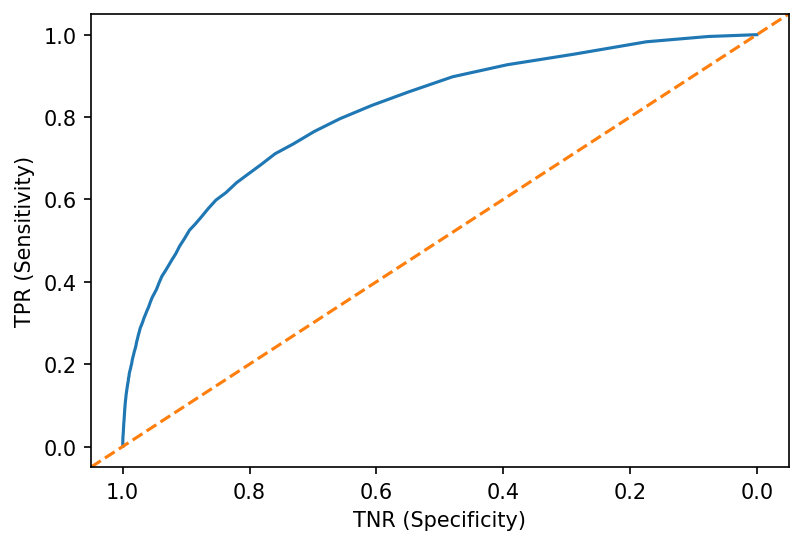

In [9]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.show()

Calculating the TPR and TNR for the break-even point in the BBB case

In [10]:
bbb_to = slow_roc(outcome, pred, cost=np.array([0.5]), margin=6)

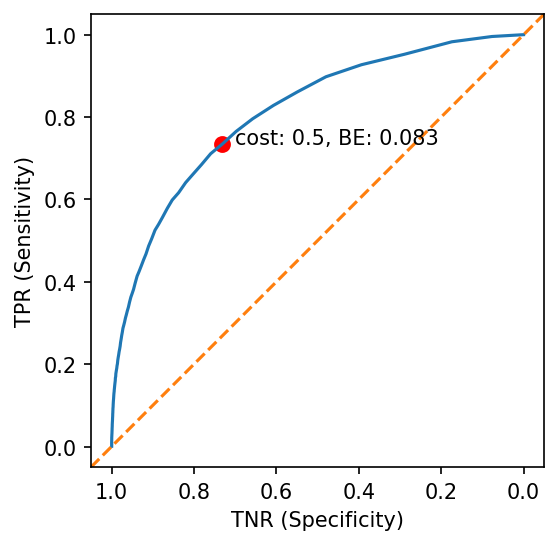

In [11]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 0.5, BE: 0.083", (bbb_to["TNR"] - 0.03, bbb_to["TPR"]))
plt.show()

In [12]:
bbb_to = slow_roc(outcome, pred, cost=np.array([6]), margin=6)

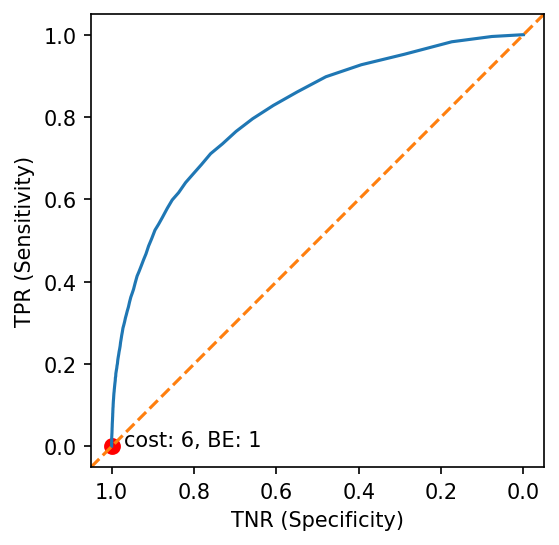

In [13]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 6, BE: 1", (bbb_to["TNR"] - 0.03, bbb_to["TPR"]))
plt.show()

In [14]:
bbb_to = slow_roc(outcome, pred, cost=np.array([0]), margin=6)

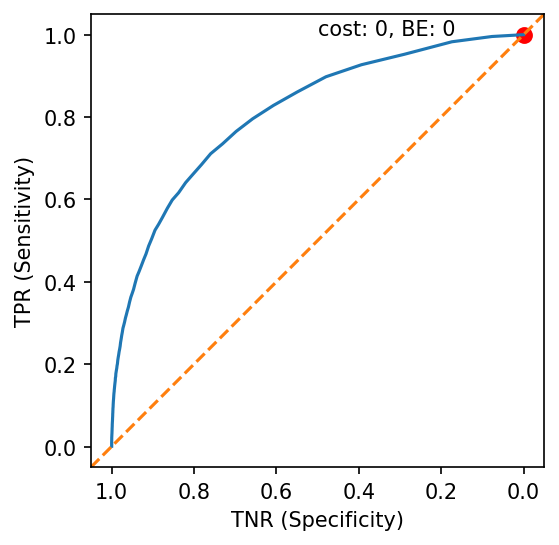

In [15]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 0, BE: 0", (bbb_to["TNR"] + 0.5, bbb_to["TPR"]))
plt.show()

Confirm plot with roc_curve from sklearn

In [16]:
fpr, tpr, thresholds = roc_curve(bbb.buyer_yes, bbb.pred_logit)
py_roc = pd.DataFrame({"FPR": fpr, "TPR": tpr})

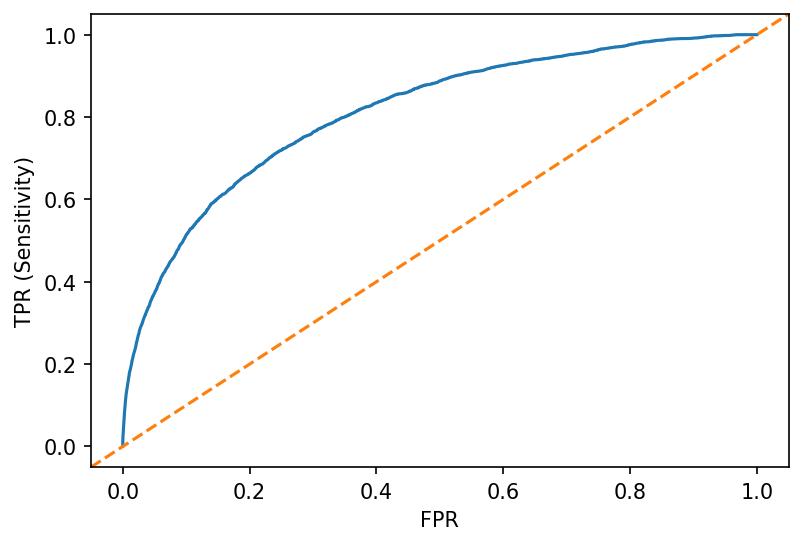

In [17]:
# slow!
plt.cla()
fig = sns.lineplot(x="FPR", y="TPR", data=py_roc)
fig.set(ylabel="TPR (Sensitivity)", xlabel="FPR")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.show()

### Probabilistic interpretation of AUC

See https://www.alexejgossmann.com/auc/ for a nice discussion

In [26]:
# Adapted from Alexej's code
s = 0
did_buy = np.where(outcome == True)[0]
did_not_buy = np.where(outcome == False)[0]


In [27]:

for i in did_buy:
    s = s + (pred[i] > pred[did_not_buy]).sum()
    s = s + (pred[i] == pred[did_not_buy]).sum() / 2

s / ((outcome == True).sum() * (outcome == False).sum())

0.811741575004971

Lets compare that result to what we would get with a formal calculation:

In [28]:
auc(fpr, tpr)

0.8117415750049711

Lets try a sampling approach

In [29]:
pred_did_buy = pred[did_buy]
pred_did_not_buy = pred[did_not_buy]
nr = 2000
(np.random.choice(pred_did_buy, nr) > np.random.choice(pred_did_not_buy, nr)).mean()

0.8195

Lets do repeated simulation as that should get us closer to the true value

In [30]:
rep = 100
s = np.array([np.nan] * rep)
for i in range(0, rep):
    s[i] = (
        np.random.choice(pred_did_buy, nr) > np.random.choice(pred_did_not_buy, nr)
    ).mean()

s.mean()

0.8115849999999999

To calculate many measures of model performance in one step, use the `evalbin` function from the `pyrsm` packages

In [22]:
rsm.evalbin(bbb, "buyer", "yes", "pred_logit", cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,pred_logit,3323,12237,33241,1199,50000,0.735,0.731,0.214,0.331,0.731,0.222,12158.0,1.0,1.563,0.311,0.812


There is also a convenience function to calculate auc in `pyrsm`

In [31]:
rsm.auc(bbb.buyer_yes, bbb.pred_logit).round(10)

0.811741575

In [32]:
fpr, tpr, thresholds = roc_curve(bbb.buyer_yes, bbb.pred_logit)
auc(fpr, tpr).round(10)

0.811741575